In [1]:
import quippy as qp

In [2]:
from ase.visualize import view

In [3]:
from ase import Atoms
from ase.lattice.cubic import SimpleCubicFactory

In [4]:
import numpy as np
import seaborn as sns
sns.set(context="talk", style="white", font_scale=1.5)
%matplotlib inline
size = 10
ratio = 0.5*(1+np.sqrt(5))
cp = sns.color_palette("colorblind")

In [5]:
class NaClFactory(SimpleCubicFactory):
    "A factory for creating NaCl (B1, Rocksalt) lattices."

    bravais_basis = [[0, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [0, 0.5, 0.5],
                     [0.5, 0, 0], [0.5, 0, 0.5], [0.5, 0.5, 0],
                     [0.5, 0.5, 0.5]]
    element_basis = (0, 1, 1, 0, 1, 0, 0, 1)


B1 = NaCl = Rocksalt = NaClFactory()

In [6]:
#From Noam - testing framework
# rotate to align (111) with z
def align_111_with_z(bulk):
    lat = bulk.get_cell()

    old_z = np.array(lat[0,:] + lat[1,:] + lat[2,:]); old_z /= np.linalg.norm(old_z)
    old_a1 = lat[0,:]
    a1_ctr_angle = np.arccos(np.dot(old_z, old_a1/np.linalg.norm(old_a1)))
    new_a1 = np.array([1.0,0.0,0.0])*np.sin(a1_ctr_angle) + np.array([0.0,0.0,1.0])*np.cos(a1_ctr_angle)
    new_other_dir = np.cross(old_z, old_a1); new_other_dir /= np.linalg.norm(new_other_dir)

    old_lat = np.zeros( (3,3) )
    new_lat = np.zeros( (3,3) )
    old_lat[:,0] = old_z # z
    old_lat[:,1] = old_a1/np.linalg.norm(old_a1) # a1
    old_lat[:,2] = new_other_dir # other dir
    new_lat[:,0] = [0.0, 0.0, 1.0]
    new_lat[:,1] = new_a1
    new_lat[:,2] = [0.0, 1.0, 0.0]

    # new_lat = m.old_lat
    # m = new_lat . old_lat_inv
    m = np.dot(new_lat, np.linalg.inv(old_lat))

    new_cell = np.dot(m, lat.T).T

    bulk.set_cell(new_cell, scale_atoms=True)

In [7]:
gete = qp.Atoms(B1(["Ge","Te"], latticeconstant=6.06))
te   = qp.Atoms(B1(["Te","Te"], latticeconstant=3.197*2))
sb   = qp.Atoms(B1(["Sb","Sb"], latticeconstant=3.103*2))

In [8]:
align_111_with_z(gete)
align_111_with_z(te)
align_111_with_z(sb)

In [9]:
import os
os.chdir("../Potentials")
pot = qp.Potential("IP GAP", param_filename="gp_merged_2bdmbd.xml")
os.chdir("../Peierls")

In [10]:
def distort(atoms, d, direction=np.array([0.0, 0.0, 1.0])):
    newcell = atoms.copy()
    pos = newcell.get_positions()
    pos[0]  += direction * d * 0.5
    pos[-1] -= direction * d * 0.5
    newcell.set_positions(pos)
    return newcell

In [11]:
def shearxy(atoms, angle):
    shear_mat = np.array([[1.0, np.tan(np.radians(angle*0.5)), 0.0 ],
                [np.tan(np.radians(angle*0.5)), 1.0, 0.0],
                [0.0, 0.0, 1.0]])
    return qp.transform(atoms, shear_mat)

In [12]:
energies_gete       = [pot.get_potential_energy(distort(gete,d)) / gete.n for d in np.linspace(-0.8, 0.8, 100)]
energies_te         = [pot.get_potential_energy(distort(te,d)) / te.n  for d in np.linspace(-1.5, 1.5, 100)]
energies_sb         = [pot.get_potential_energy(distort(sb,d)) / sb.n for d in np.linspace(-0.8, 0.8, 100)]

In [13]:
energies_te_inset   = [pot.get_potential_energy(distort(te,d)) / te.n  for d in np.linspace(-0.5, 0.5, 100)]

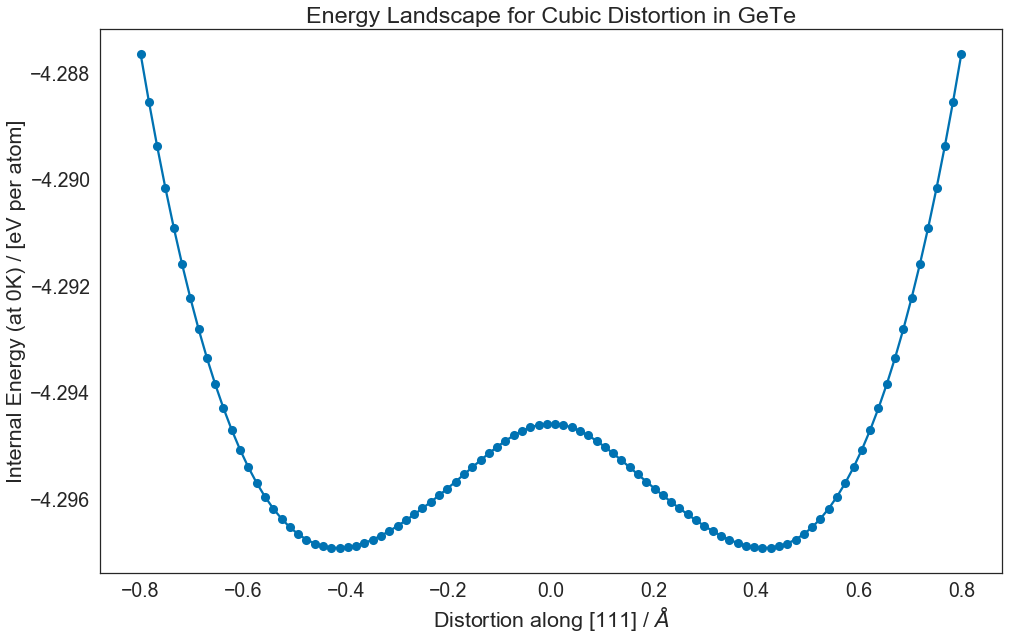

In [14]:
fig = sns.plt.figure(figsize=(ratio*size, size))
sns.plt.plot(np.linspace(-0.8, 0.8, 100), energies_gete, "o-", color = cp[0]);
sns.plt.title('Energy Landscape for Cubic Distortion in GeTe')
sns.plt.xlabel("Distortion along [111] / $\\AA$");
sns.plt.ylabel("Internal Energy (at 0K) / [eV per atom]")
sns.plt.savefig("peierlsGeTe.pdf")

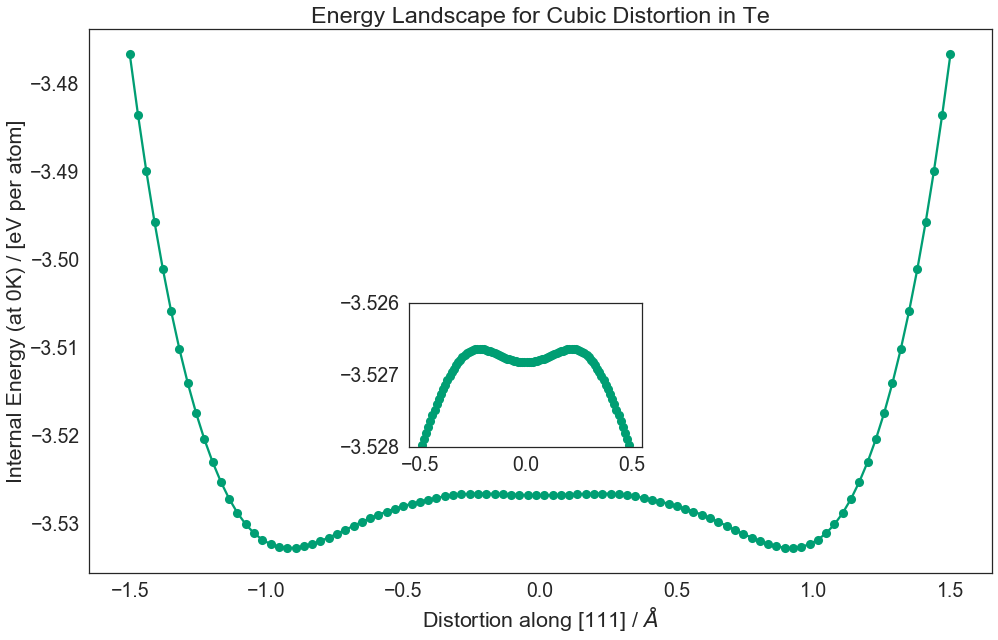

In [15]:
fig = sns.plt.figure(figsize=(ratio*size, size));
sns.plt.title('Energy Landscape for Cubic Distortion in Te')
sns.plt.plot(np.linspace(-1.5, 1.5, 100), energies_te, "o-", color = cp[1]);
sns.plt.xlabel("Distortion along [111] / $\\AA$");
sns.plt.ylabel("Internal Energy (at 0K) / [eV per atom]");

a = sns.plt.axes([.4, .3, .2, .2])
sns.plt.plot(np.linspace(-0.5, 0.5, 100), energies_te_inset, "o-", color = cp[1]);
sns.plt.ylim(-3.528, -3.526)

sns.plt.savefig("peierlsTe.pdf");

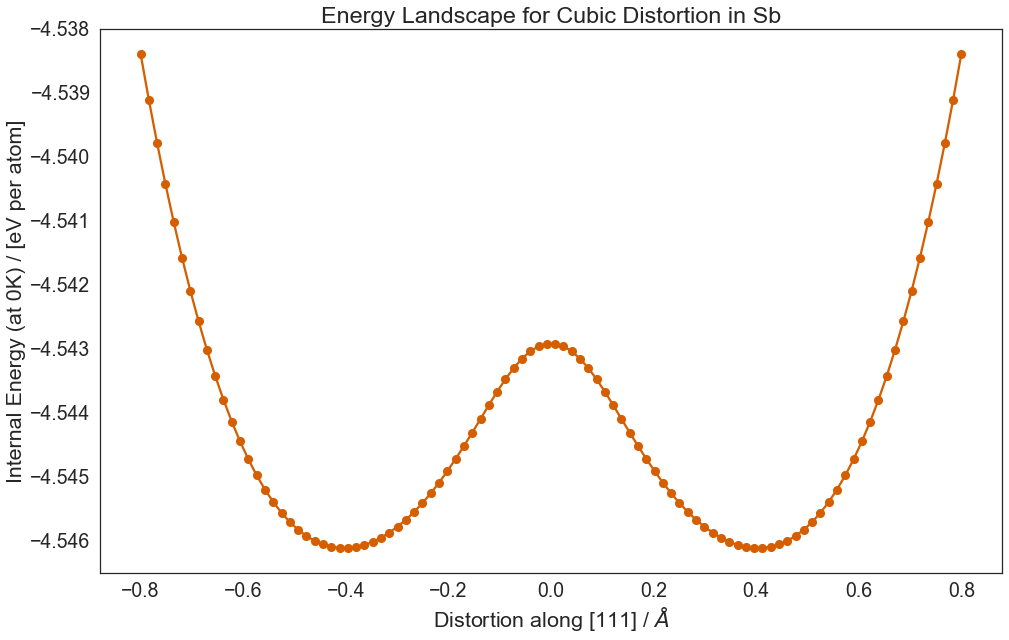

In [16]:
fig = sns.plt.figure(figsize=(ratio*size, size))
sns.plt.plot(np.linspace(-0.8, 0.8, 100), energies_sb, "o-", color = cp[2]);
sns.plt.title('Energy Landscape for Cubic Distortion in Sb')
sns.plt.xlabel("Distortion along [111] / $\\AA$");
sns.plt.ylabel("Internal Energy (at 0K) / [eV per atom]")
sns.plt.savefig("peierlsSb.pdf")

In [17]:
energies_gete       = [pot.get_potential_energy(shearxy(gete,angle)) / gete.n for angle in np.linspace(-20, 20, 100)]
energies_te         = [pot.get_potential_energy(shearxy(te,angle)) / te.n  for angle in np.linspace(-20, 20, 100)]
energies_sb         = [pot.get_potential_energy(shearxy(sb,angle)) / sb.n for angle in np.linspace(-20, 20, 100)]

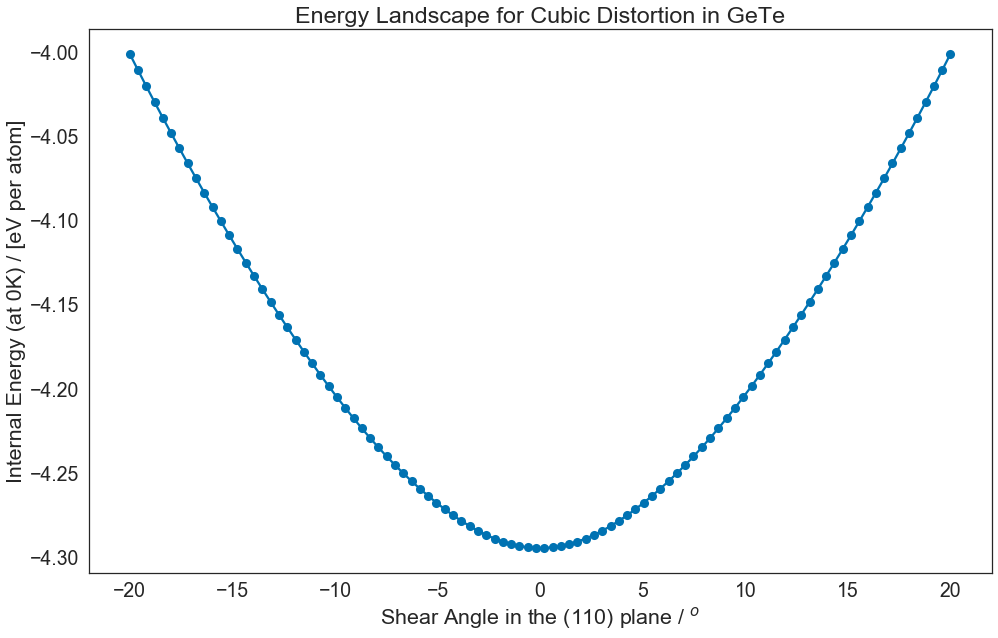

In [18]:
fig = sns.plt.figure(figsize=(ratio*size, size))
sns.plt.plot(np.linspace(-20, 20, 100), energies_gete, "o-", color = cp[0]);
sns.plt.title('Energy Landscape for Cubic Distortion in GeTe')
sns.plt.xlabel("Shear Angle in the (110) plane / $^o$");
sns.plt.ylabel("Internal Energy (at 0K) / [eV per atom]")
sns.plt.savefig("shearGeTe.pdf")

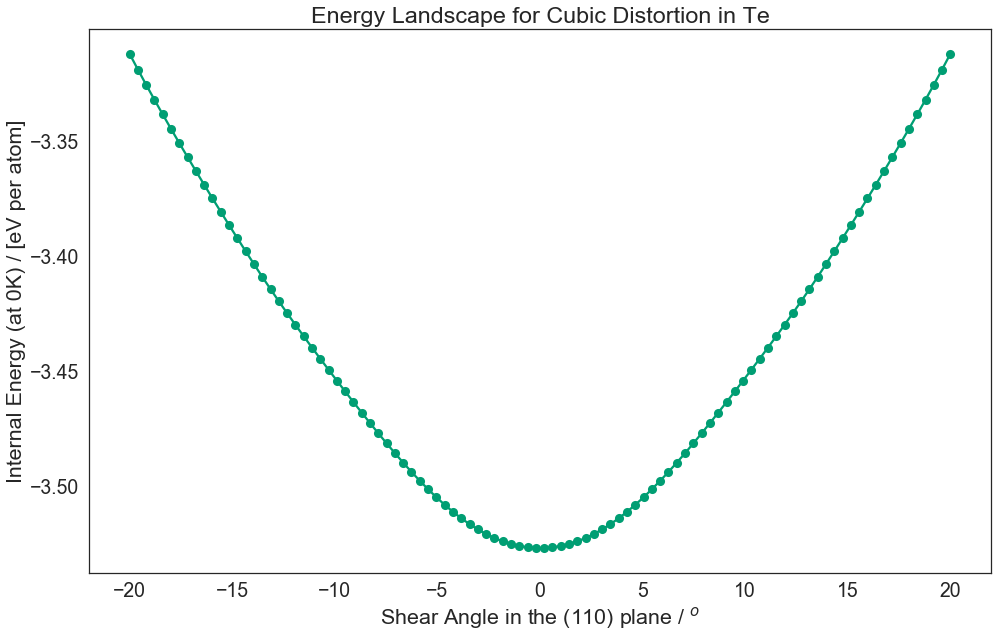

In [19]:
fig = sns.plt.figure(figsize=(ratio*size, size))
sns.plt.plot(np.linspace(-20, 20, 100), energies_te, "o-", color = cp[1]);
sns.plt.title('Energy Landscape for Cubic Distortion in Te')
sns.plt.xlabel("Shear Angle in the (110) plane / $^o$");
sns.plt.ylabel("Internal Energy (at 0K) / [eV per atom]")
sns.plt.savefig("shearTe.pdf")

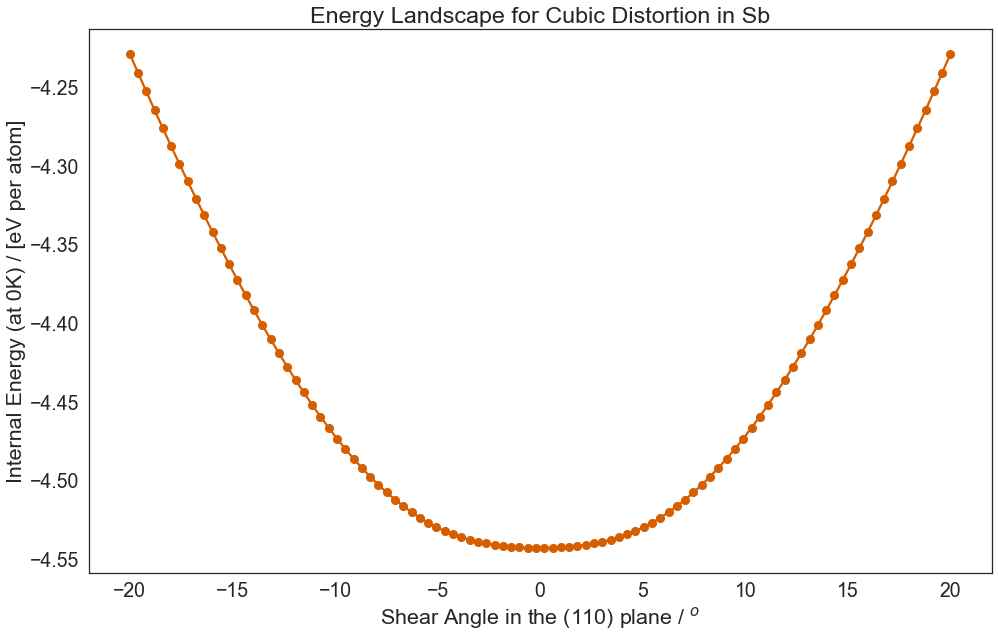

In [20]:
fig = sns.plt.figure(figsize=(ratio*size, size))
sns.plt.plot(np.linspace(-20, 20, 100), energies_sb, "o-", color = cp[2]);
sns.plt.title('Energy Landscape for Cubic Distortion in Sb')
sns.plt.xlabel("Shear Angle in the (110) plane / $^o$");
sns.plt.ylabel("Internal Energy (at 0K) / [eV per atom]")
sns.plt.savefig("shearSb.pdf")

In [21]:
from scipy.interpolate import interp2d

In [22]:
n = 25
distances = np.linspace(-1.0, 1.0, n)
angles = np.linspace(-5, 5, n)
energies_gete = np.array([[ (pot.get_potential_energy(shearxy(distort(gete,d), angle))) / gete.n \
                             for d in distances] for angle in angles])
f = interp2d(distances, angles, energies_gete, kind="quintic")
distances = np.linspace(-1.0, 1.0, 100*n)
angles = np.linspace(-5, 5, 100*n)
interpolated_energies_gete = f(distances, angles)

distances = np.linspace(-1.5, 1.5, n)
angles = np.linspace(-5, 5, n)
energies_te = np.array([[ (pot.get_potential_energy(shearxy(distort(te,d), angle))) / te.n \
                             for d in distances] for angle in angles])
f = interp2d(distances, angles, energies_te, kind="quintic")
distances = np.linspace(-1.5, 1.5, 100*n)
angles = np.linspace(-5, 5, 100*n)
interpolated_energies_te = f(distances, angles)

distances = np.linspace(-1.0, 1.0, n)
angles = np.linspace(-5, 5, n)
energies_sb = np.array([[ (pot.get_potential_energy(shearxy(distort(sb,d), angle))) / sb.n \
                             for d in distances] for angle in angles])
f = interp2d(distances, angles, energies_sb, kind="quintic")
distances = np.linspace(-1.0, 1.0, 100*n)
angles = np.linspace(-5, 5, 100*n)
interpolated_energies_sb = f(distances, angles)

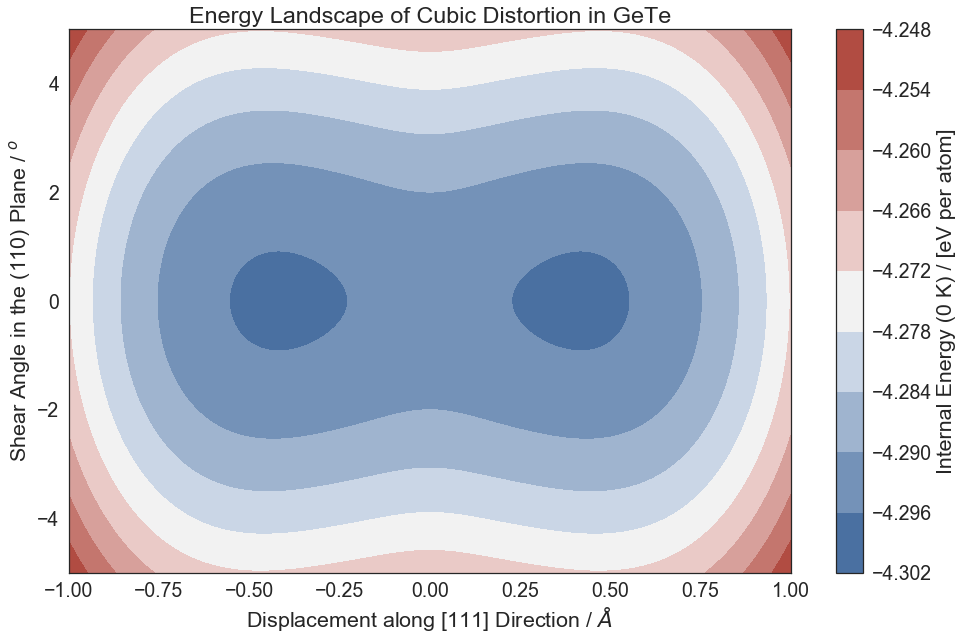

In [33]:
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=15, as_cmap=True)
sns.plt.figure(figsize = (ratio*size, size));
sns.plt.title("Energy Landscape of Cubic Distortion in GeTe");
distances = np.linspace(-1.0, 1.0, 100*n);
angles = np.linspace(-5, 5, 100*n);
cp = sns.plt.contourf(distances, angles, interpolated_energies_gete, cmap = cmap);
cb = sns.plt.colorbar();
cb.set_label("Internal Energy (0 K) / [eV per atom]");
sns.plt.xlabel("Displacement along [111] Direction / $\\AA$");
sns.plt.ylabel("Shear Angle in the (110) Plane / $^o$");
sns.plt.savefig("PeierlsGeTe.pdf")

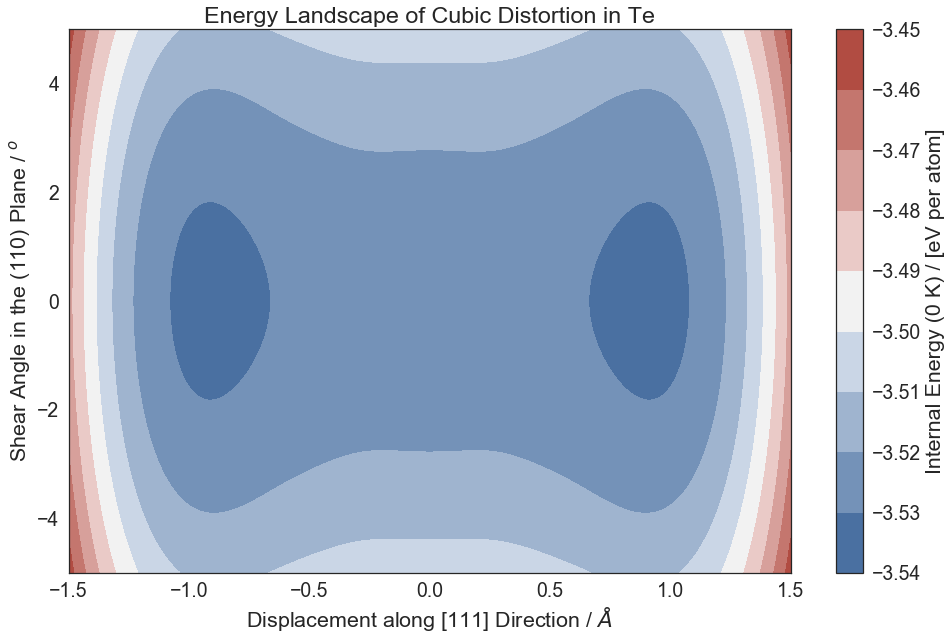

In [34]:
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=15, as_cmap=True)
sns.plt.figure(figsize = (ratio*size, size));
sns.plt.title("Energy Landscape of Cubic Distortion in Te");
distances = np.linspace(-1.5, 1.5, 100*n);
angles = np.linspace(-5, 5, 100*n);
cp = sns.plt.contourf(distances, angles, interpolated_energies_te, cmap = cmap);
cb = sns.plt.colorbar();
cb.set_label("Internal Energy (0 K) / [eV per atom]");
sns.plt.xlabel("Displacement along [111] Direction / $\\AA$");
sns.plt.ylabel("Shear Angle in the (110) Plane / $^o$");
sns.plt.savefig("PeierlsTe.pdf")

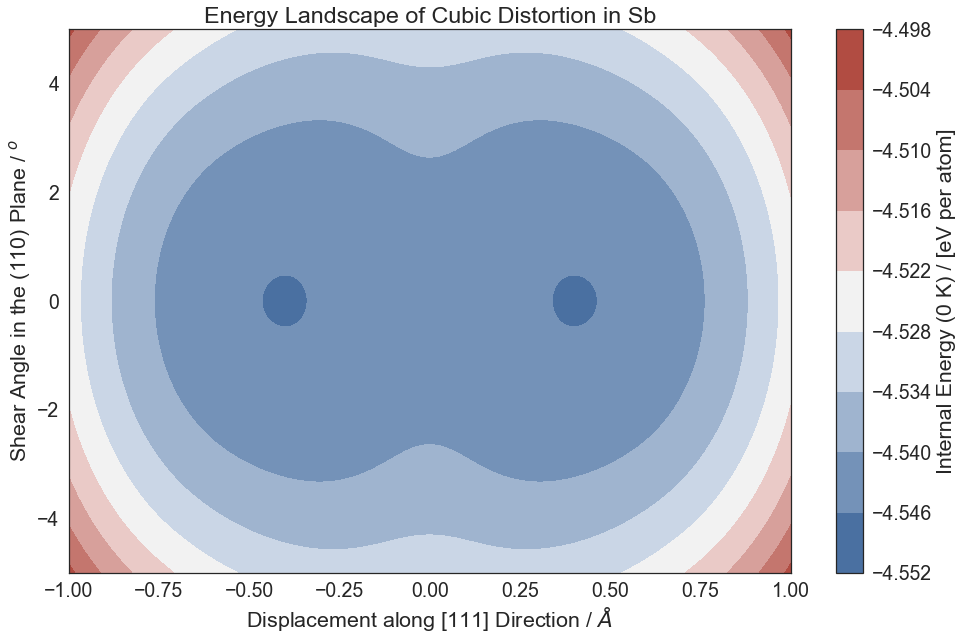

In [35]:
#cmap = sns.choose_diverging_palette(as_cmap=True);
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=15, as_cmap=True)
sns.plt.figure(figsize = (ratio*size, size));
distances = np.linspace(-1.0, 1.0, 100*n);
angles = np.linspace(-5, 5, 100*n);
sns.plt.title("Energy Landscape of Cubic Distortion in Sb");
cp = sns.plt.contourf(distances, angles, interpolated_energies_sb, cmap = cmap);
cb = sns.plt.colorbar();
cb.set_label("Internal Energy (0 K) / [eV per atom]");
sns.plt.xlabel("Displacement along [111] Direction / $\\AA$");
sns.plt.ylabel("Shear Angle in the (110) Plane / $^o$");
sns.plt.savefig("PeierlsSb.pdf")